# Visualizing spatial data in Python

## Getting data
We'll fetch and map NWIS gage site data

In [1]:
#Import pandas
import pandas as pd

In [42]:
#Get the list of site names for NC using the NWIS API
theURL = ('https://waterdata.usgs.gov/nwis/inventory?' + \
          'state_cd=nc&' + \
          'group_key=NONE&' + \
          'format=sitefile_output&' + \
          'sitefile_output_format=rdb&' + \
          'column_name=site_no&' + \
          'column_name=station_nm&' + \
          'column_name=site_tp_cd&' + \
          'column_name=dec_lat_va&' + \
          'column_name=dec_long_va&' + \
          'column_name=drain_area_va&' + \
          'list_of_search_criteria=state_cd')
colnames=['site_no','station_nm','site_tp_cd','lat','lng','agent','datum','d_area']

#Pull the data from the URL
dfNWIS = pd.read_csv(theURL,skiprows=29,sep='\t',names=colnames,index_col='site_no')

#Drop rows with null values
dfNWIS.dropna(inplace=True)

#Display
dfNWIS.head()

,station_nm,site_tp_cd,lat,lng,agent,datum,d_area
site_no,,,,,,,
2043410,"NORTHWEST RIVER ABOVE MOUTH NEAR MOYOCK, NC",ST,36.512222,-76.086667,S,NAD83,196.00
2043415,"TULL CREEK AT SR 1222 NEAR CURRITUCK, NC",ST,36.496389,-76.084167,S,NAD83,52.00
2043750,CROSS CANAL DITCH NR HOLLY GROVE NC,ST-DCH,36.509875,-76.552450,U,NAD83,23.40
2043760,"FOLLY SWAMP NEAR SANBURY, NC",ST,36.488486,-76.574672,S,NAD83,3.42
2043828,"PASQUOTANK RIVER NR SOUTH MILLS, NC",ST,36.421821,-76.346885,U,NAD83,208.00


## Setting up to visualize our data
We are going to construct a map, and when we do, we'll have to specify where our map should be centered and how far zoomed it should be. To compute the center, we can easily compute the median Lat and Long values from our data...

In [5]:
#Determine the median lat/lng
medianLat = dfNWIS['lat'].median()
medianLng = dfNWIS['lng'].median()
print (medianLat,medianLng)

35.6862693 -79.1066796


## Visualizing with the `folium` package
https://python-visualization.github.io/folium/

Folium is a Python wrapper for the JavaScript "Leaflet" Package...

In [3]:
import folium
folium.__version__

'0.10.0'

In [12]:
#Construct the map
m = folium.Map(location=[medianLat,medianLng],
               zoom_start = 7,
               tiles='Stamen Watercolor'              
             )
#Display the map
m

Try:
* Change the zoom value: does higher or lower values zoom in to a smaller area?
* Change the tiles to `Stamen Terrain`,`Stamen Watercolor`, `Stamen Toner`. [more](https://python-visualization.github.io/folium/quickstart.html#Getting-Started).

In [14]:
#Create the marker, we'll use a circle Marker
myMarker = folium.CircleMarker(location=[medianLat,medianLng],
                               color='red',
                               fill=True,
                               fill_opacity=0.5,
                               radius=30,
                               tooltip='Map Center'
                              )
myMarker.add_to(m)
m

In [19]:
#Recreate the map object to clear markers
m = folium.Map(location=[medianLat,medianLng],
               zoom_start = 7,
               tiles='OpenStreetMap'              
             )

#Loop through all features and add them to the map as markers
for row in dfNWIS.itertuples():
    #Get info for the record
    lat = row.lat
    lng = row.lng
    site_no = row.station_nm
    #Create the marker object, adding them to the map object
    folium.CircleMarker(location=[lat,lng],
                        color='blue',
                        fill=True,
                        fill_opacity=0.6,
                        radius=3,
                        tooltip=site_no
                       ).add_to(m)
#Show the map
m

---
## GeoPandas
GeoPandas has some plotting capabilities.

In [36]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Point

In [24]:
#Create point objects from our coordinate fields
thePoints = [Point(xy) for xy in zip(dfNWIS['lng'],dfNWIS['lat'])]

In [26]:
#Convert the dataframe to a geodataframe
gdfNWIS = gpd.GeoDataFrame(dfNWIS,geometry=thePoints,crs={'init:''epsg:4326'})

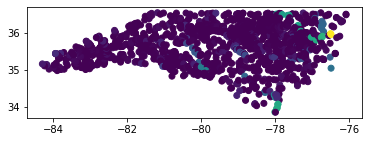

In [29]:
#Plot the data
%matplotlib inline
gdfNWIS.plot();

In [45]:
import matplotlib.pyplot as plt

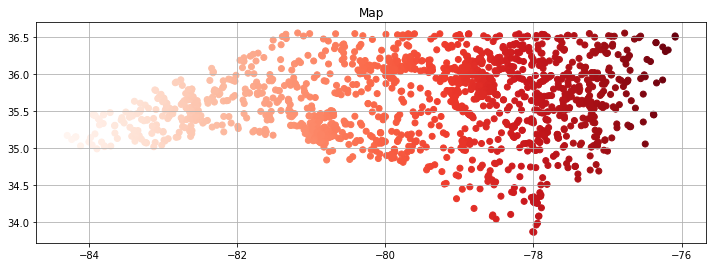

In [54]:
gdfNWIS.plot('lng', cmap='Reds',figsize=(12,8))
#Add aesthetics via the matplotlib pyplt interface
plt.title("Map")
plt.grid()
plt.plot();

## ArcGIS Python API

In [ ]:
#